# N-Beats for the Web Traffic Forecasting dataset

A quick and dirty application of the n-beats architecture for time series forecasting using data from this kaggle competition. The original objective was to generate predictions for 165k series. In this notebook we will use just a small sample to see how the neural network performs on small datasets

## Setting up

I originally ran on google colab and had the data stored on my personal drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (8, 8)

## N-Beats

Just defining the objects to build the neural net

### Blocks

Here I define the blocks which are the bulk of the n-beats architecture. 

First I create a function to quickly create a MLP architecture, which is the base of each type of block, after, I set up functions to create the expansion coefficients for the interpretable version of n-beats.

Lastly, I define each type of block, Generic, Trend and Seasonal.

In [3]:
def linear_stack(horizon, scale, width, activation=False, bias=True, layers=4):
    """
    Creates a simple MLP, these are the foundation of each type of block proposed in the n-beats paper.
    
    Arguments:
    horizon: The forecast period
    scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
    width: Number of nodes in each layer
    activation: Activation function. Pass False if none required
    bias: Include bias in each linear node?
    layers: Number of layers    
    """
    
    head = [nn.Linear(horizon*scale, width, bias)]
    fc = [nn.Linear(width, width, bias)]
    
    if activation:
        head.append(activation)
        fc.append(activation)
    
    stack = nn.Sequential(*head + fc*(layers-1))
    
    return stack

def create_trend(length, p):
    """
    Creates the expansion coefficients to force an increasing trend in each stack.
    
    Arguments:
    length: Size of the input data
    p: Desired polynomial degree. Typical is 2 to 3
    """
    
    t = np.arange(0, length)/length
    T = torch.tensor([np.power(t ,i) for i in range(p+1)], dtype=torch.float)
    
    return T

def create_season(horizon, scale):
    """
    Creates the expansion coefficients to add regular seasonality in each stack.
    
    Arguments:
    horizon: The forecast period
    scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
    """
    backcast_size = horizon*scale
    
    frequency = np.append(np.zeros(1), np.arange(scale, scale / 2 * horizon) / scale).reshape((1, -1))
    backcast_grid = 2 * np.pi * (np.arange(backcast_size) / horizon).reshape((-1, 1)) * frequency
    forecast_grid = 2 * np.pi * (np.arange(horizon) / horizon).reshape((-1, 1)) * frequency
    
    return torch.tensor(backcast_grid, dtype=torch.float), torch.tensor(forecast_grid, dtype=torch.float)

In [4]:
class GenericBlock(nn.Module):
    def __init__(self, horizon, scale, width, layers, theta_len):
        """
        The generic block as described on the paper. This might not generate interpretable outputs.

        Arguments:
        horizon: The forecast period
        scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
        width: Number of nodes in each layer
        layers: Number of layers    
        theta_len: The size of the non-interpretable expansion coefficients
        """
        super().__init__()
            
        backcast_length = horizon*scale
        
        self.fc_layers = linear_stack(horizon, scale, width, activation=nn.ReLU(inplace=True), bias=True, layers=layers)
        self.backcast = nn.Sequential(nn.Linear(width, theta_len, bias=False), 
                                     nn.Linear(theta_len, backcast_length, bias=True)
                                     )
        
        self.forecast = nn.Sequential(nn.Linear(width, theta_len, bias=False), 
                                     nn.Linear(theta_len, horizon, bias=True)
                                     )
        
    def forward(self, x):
        x1 = self.fc_layers(x)
        backcast = self.backcast(x1)
        forecast = self.forecast(x1)
        
        return backcast, forecast

In [5]:
class TrendBlock(nn.Module):
    def __init__(self, horizon, scale, width, layers, p):
        """
        The trend block as described on the paper. Outputs from this block should resemble a linear trend.
    
        Arguments:
        horizon: The forecast period
        scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
        width: Number of nodes in each layer
        layers: Number of layers 
        p: Desired polynomial degree. Typical is 2 to 3
        """
        super().__init__()
        
        self.size = p+1
        
        backcast_length = horizon*scale
        theta_len = 2*self.size
        
        self.trend_back = nn.Parameter(create_trend(backcast_length, p), requires_grad=False)
        self.trend_forward = nn.Parameter(create_trend(horizon, p), requires_grad=False)
        
        self.fc_layers = linear_stack(horizon, scale, width, activation=nn.ReLU(inplace=True), bias=True, layers=layers)
        self.basis = nn.Linear(width, theta_len, bias=False)
                                     
    def forward(self, x):
        x1 = self.fc_layers(x)
        theta = self.basis(x1)
        backcast = torch.einsum('bp,pt->bt', theta[:, :self.size], self.trend_back)
        forecast = torch.einsum('bp,pt->bt', theta[:, self.size:], self.trend_forward)

        return backcast, forecast

In [6]:
class SeasonalBlock(nn.Module):
    def __init__(self, horizon, scale, width, layers):
        """
        The seasonal block as described on the paper. Outputs from this block should resemble a sinoid or cosine function.

        Arguments:
        horizon: The forecast period
        scale: The scale parameter, this times horizon is the lookback period that serves as input to generate predictions
        width: Number of nodes in each layer
        layers: Number of layers 
        """
        super().__init__()

        backcast_length = horizon*scale
        theta_len = 4 * int(np.ceil(scale / 2 * horizon) - (scale - 1))

        backcast_grid, forecast_grid = create_season(horizon, scale)

        backcast_grid = torch.transpose(backcast_grid, 0, 1)
        forecast_grid = torch.transpose(forecast_grid, 0, 1)

        self.fc_layers = linear_stack(horizon, scale, width, activation=nn.ReLU(inplace=True), bias=True, layers=layers)
        self.basis = nn.Linear(width, theta_len, bias=False)

        self.cos_backcast = nn.Parameter(torch.cos(backcast_grid), requires_grad=False)
        self.sin_backcast = nn.Parameter(torch.sin(backcast_grid), requires_grad=False)

        self.cos_forecast = nn.Parameter(torch.cos(forecast_grid), requires_grad=False)
        self.sin_forecast = nn.Parameter(torch.sin(forecast_grid), requires_grad=False)

    def forward(self, x):        
        x1 = self.fc_layers(x)
        x1 = self.basis(x1)
        
        quarters = x1.shape[1]//4
        
        backcast_cos = torch.einsum('bp,pt->bt', x1[:, :quarters], self.cos_backcast)
        backcast_sin = torch.einsum('bp,pt->bt', x1[:, quarters:2*quarters], self.sin_backcast)
        backcast = backcast_cos + backcast_sin
        
        forecast_cos = torch.einsum('bp,pt->bt', x1[:, 2*quarters:3*quarters], self.cos_forecast)
        forecast_sin = torch.einsum('bp,pt->bt', x1[:, 3*quarters:], self.sin_forecast)
        forecast = forecast_cos + forecast_sin
                
        return backcast, forecast 

### Stack

Code to create a stack from a list of blocks. Might be redundant with the module that creates the network

In [7]:
class NStack(nn.Module):
    def __init__(self, horizon, block, num_blocks, weight_sharing):
        """
        Defines a stack which is a series of blocks which decompose the input data
        
        Arguments:
        horizon: The forecast period
        block: A list composed of the block objects
        num_blocks: Number of blocks in each stack
        weight_sharing: Should every block in the stack have the same weights?
        """
        super().__init__()
        
        self.horizon = horizon
        self.num_blocks = num_blocks
        self.weight_sharing = weight_sharing
        
        if not self.weight_sharing:
            block_list = [block]*self.num_blocks
            self.blocks = nn.ModuleList(block_list)
        else:
            self.blocks = block
        
    def forward(self, x, batch_size):
        forecasts = torch.empty((batch_size, self.num_blocks, self.horizon))
        for bi in range(self.num_blocks):
            if self.weight_sharing:
                backcast, forecast = self.blocks(x)
            else:
                block = self.blocks[bi]
                backcast, forecast = block(x)
            x = x - backcast
            forecasts[:, bi, :] = forecast
        
        return x, forecasts.sum(1)

### Network

Module to create the network architecture and some quick functions to implement the two types of n-beats described on the paper

In [8]:
class NBeats(nn.Module):
    def __init__(self, horizon, block_list, num_blocks, weight_sharing):
        """
        Defines the network architecture
        
        Arguments:
        horizon: The forecast period
        block: A list composed of the block objects
        num_blocks: Number of blocks in each stack
        weight_sharing: Should every block in the stack share have the same weights?
        """
        super().__init__()
        stacks_list = [NStack(horizon, block, num_blocks, weight_sharing) for block in block_list]
        
        self.horizon = horizon
        self.num_stacks = len(block_list)
        self.stacks = nn.ModuleList(stacks_list)
        
    def forward(self, x, batch_size):
        forecasts = torch.empty((batch_size, self.num_stacks, self.horizon))
        for s in range(len(self.stacks)):
            stack = self.stacks[s]
            backcast, forecast = stack(x, batch_size)
            x = x - backcast
            forecasts[:, s, :] = forecast
        
        if torch.cuda.is_available():
            x, forecasts = x.cuda(), forecasts.cuda()
        
        return x, forecasts.sum(1)

In [9]:
def create_nbeats_g(horizon, scale, width, layers, theta_len, num_blocks, num_stacks):
    
    block_list = [GenericBlock(horizon, scale, width, layers, theta_len) for _ in range(num_stacks)]
    
    return NBeats(horizon, block_list, num_blocks, False)

def create_nbeats_i(horizon, scale, t_width, t_layers, t_p, s_width, s_layers, num_blocks):
    
    block_list = [TrendBlock(horizon, scale, t_width, t_layers, t_p), SeasonalBlock(horizon, scale, s_width, s_layers)]
    
    return NBeats(horizon, block_list, num_blocks, True)

## Reading the data

Getting the data as a pandas dataframe and replacing any missing value with a 0. It is not the smartest way, but it is simple enough for this example.

In [10]:
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train_1.csv.zip')

train_data.fillna(value=0, inplace=True)

In [11]:
n_samples = 100 # We will use only a 100 time series. It should be enough to assess the quality of the architecture in this kind of data

sample_train = train_data.sample(n=n_samples, random_state=1)

## Model training

We have about 500 observations for each time series, therefore, to estimate the quality of each model, we will do a k-fold cross validation.

For the training loop, we will run a _n_ amount of batches instead of epochs, therefore, the _generate_batch_ function will take random points and create our Xs and Ys according to out lookback and forecast periods

In [12]:
def create_splits(array, k=3, h=60):
    """
    Takes a numpy array, separates it into 'k' train/validation combinations based on the k*h last indexes of the array 
    array: Input data to split between train and validation
    n: Number of splits
    h: Size of forecast period
    """
    
    size = array.shape[0]
    train = np.zeros((k, size-(h*k)))
    validation = np.zeros((k, h))

    for i in range(k):
        train[i, :] = array[(h*i):size-(h*(k-i))]
        validation[i, :] = array[size-(h*(k-i)):size-(h*(k-i-1))]
    
    return train, validation

def generate_batch(data, h, scale, batch_size): 
    
    n = data.shape[0]
    
    indexes = np.random.randint(low=h*scale, high=n-h, size=batch_size)
    x = np.zeros((batch_size, h*scale))
    y = np.zeros((batch_size, h))
    
    for i in range(batch_size):
        x[i, :] = data[indexes[i]-(h*scale):indexes[i]]
        y[i, :] = data[indexes[i]:indexes[i]+h]
    
    return x, y

Basic training loop and defining some useful losses

In [13]:
def train_loop(model, train, validation, optimizer, batch_size, n_batches, record_every=25, print_loss=True):
    if on_gpu:
        model.cuda()
        validation = torch.from_numpy(validation).float().cuda().view((1, -1))
        validation_x = torch.from_numpy(train[-h*scale:].reshape((1, -1))).float().cuda()

    counter = 0

    train_losses = []
    val_losses = []

    for i in range(n_batches):
        counter += 1
        model.train()
        model.zero_grad()
        
        x, y = generate_batch(data=train, h=h, scale=scale, batch_size=batch_size)
        x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
        if on_gpu:
            x, y = x.cuda(), y.cuda()
        
        backcasts, forecasts = model(x, batch_size)
        
        loss = criterion(forecasts, y)
        loss.backward()
        optimizer.step()
        
        if counter % record_every == 0:
            with torch.no_grad():
                model.eval()
                val_backcasts, val_forecasts = model(validation_x, 1)
                val_loss = criterion(val_forecasts, validation)
                
                train_losses.append(loss.item())
                val_losses.append(val_loss.item())
            
            if print_loss:
                print(f'Batch: {i+1}/{n_batches}', f'Train loss: {loss:.4f}', f'Validation loss: {val_loss:.4f}')
    
    return train_losses, val_losses

In [14]:
def mape_loss(output, target):
    mape = torch.mean(torch.abs(output - target)/target)
    
    return mape

def smape_loss(output, target):
    numerator = torch.abs(output - target)
    denominator = ((torch.abs(output) + torch.abs(target)) / 2)
    smape = torch.mean(numerator/denominator)

    return smape

We loop through all the arrays fitting a specific model for each and at the end saving the train and validation losses

In [16]:
training_array = sample_train.iloc[:, 1:].to_numpy()

In [17]:
%%time

# Create training loop for validation with all the sampled ts

states_dict = {}
h = 60
scale = 2
k = 3


on_gpu = torch.cuda.is_available()
# criterion = nn.L1Loss()
criterion = smape_loss

for index in range(n_samples):
    print(f'------ STARTING ARRAY: {index} ------')
    states_dict[index] = {'train_loss': [], 'validation_loss': []}
    splits = create_splits(training_array[index, :])
    for cv_index in range(3):
        #print(f'------ STARTING SPLIT: {cv_index} ------')
        train_cv = splits[0][cv_index]
        validation_cv = splits[1][cv_index]
        generic_model = create_nbeats_g(h, scale, 512, 4, 64, 1, 30)
        optimizer = optim.Adam(generic_model.parameters())

        train_loss, val_loss = train_loop(model=generic_model, train=train_cv, validation=validation_cv, optimizer=optimizer, batch_size=32, n_batches=200, record_every=25, print_loss=False)
        states_dict[index]['train_loss'].append(train_loss)
        states_dict[index]['validation_loss'].append(val_loss)
    
    states_dict[index]['train_loss'], states_dict[index]['validation_loss'] = np.array(states_dict[index]['train_loss']), np.array(states_dict[index]['validation_loss'])

------ STARTING ARRAY: 0 ------
------ STARTING ARRAY: 1 ------
------ STARTING ARRAY: 2 ------
------ STARTING ARRAY: 3 ------
------ STARTING ARRAY: 4 ------
------ STARTING ARRAY: 5 ------
------ STARTING ARRAY: 6 ------
------ STARTING ARRAY: 7 ------
------ STARTING ARRAY: 8 ------
------ STARTING ARRAY: 9 ------
------ STARTING ARRAY: 10 ------
------ STARTING ARRAY: 11 ------
------ STARTING ARRAY: 12 ------
------ STARTING ARRAY: 13 ------
------ STARTING ARRAY: 14 ------
------ STARTING ARRAY: 15 ------
------ STARTING ARRAY: 16 ------
------ STARTING ARRAY: 17 ------
------ STARTING ARRAY: 18 ------
------ STARTING ARRAY: 19 ------
------ STARTING ARRAY: 20 ------
------ STARTING ARRAY: 21 ------
------ STARTING ARRAY: 22 ------
------ STARTING ARRAY: 23 ------
------ STARTING ARRAY: 24 ------
------ STARTING ARRAY: 25 ------
------ STARTING ARRAY: 26 ------
------ STARTING ARRAY: 27 ------
------ STARTING ARRAY: 28 ------
------ STARTING ARRAY: 29 ------
------ STARTING ARRA

At the end, we plot the k-fold validation loss with the averages. The model seems quite unstable and not very good. This might be because we overfit or the data is very erratic.

Some possible next steps would be:
* Try some regularization, specially dropout, to apply some constraints to the model
* Maybe one model for all the series could perform well, but that would require some changes to how we generate the batches

In [18]:
last_batch_train_loss = np.zeros((n_samples, k))
last_batch_validation_loss = np.zeros((n_samples, k))

for index in range(n_samples):
    last_batch_train_loss[index, :] = states_dict[index]['train_loss'][:, -1]
    last_batch_validation_loss[index, :] = states_dict[index]['validation_loss'][:, -1]


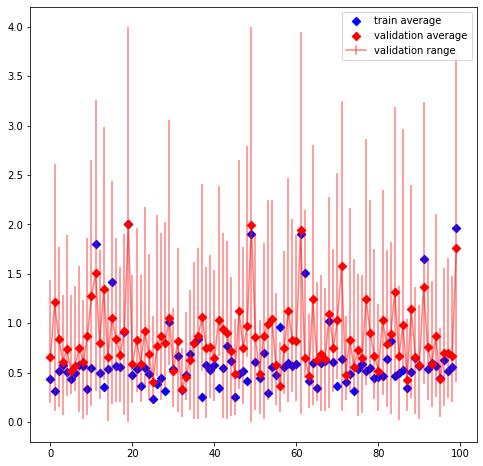

In [38]:
fig, ax = plt.subplots()


train_mean, validation_mean = np.mean(last_batch_train_loss, axis=1), np.mean(last_batch_validation_loss, axis=1)
x = range(n_samples)

ax.errorbar(x=x, y=validation_mean, yerr=np.array([np.min(last_batch_validation_loss, axis=1), np.max(last_batch_validation_loss, axis=1)]), 
            label='validation range', color='red', alpha=0.5)
ax.scatter(x=x, y=train_mean, label='train average',  color='blue', marker='D')
ax.scatter(x=x, y=validation_mean, label='validation average', color='red', marker='D')
ax.legend()


fig.show()

Lastly, simply to confirm, our validation smape is about 84%, on average. The leading competition winner had a smape equal to 35.48%, approximately.

So, yeah, currently the model is quite bad

In [ ]:
last_batch_train_loss.mean()

0.6231086341540019

In [ ]:
last_batch_validation_loss.mean()

0.8401647633810839